# Import modules needed

In [1]:
import numpy as np
import random
from scipy.spatial import distance
import matplotlib.pyplot as plt
from tqdm import tqdm

# Functions

These functions below deal with the Elmegreen fractal generating algorithm itself.

The funtion `coord_func` is equivalent to the equation:

$$
x_n = x_{n-1} + \frac{|2\mathcal{L} - 1 |}{\mathcal{S}^g}
$$

where $\mathcal L$ is a linear random deviate on the interval $[0,1]$, $\mathcal S$ is the scaling parameter as described by Elmegreen (1997), and $g$ is the generation. This function generates $\mathcal F$ values of $x_n$, described as the number of children.

The function `fractal_point_gen` defines the logic needed to generate the points which constitute the fractal field.

In [42]:
def coord_func(x,S,g,F):
    L = np.random.random(F)
    return x + 2*(L-0.5)/S**g

def fractal_point_gen(integer,G,D,E=2,S=None,F=None,N_points=None):
    if integer == 'S':
        F=S**D
        F_st = int(F+0.5)
        F_lo = int(F)
        F_hi = F_lo+1
        F_change = F - F_lo
        randoms = np.random.random(G-1)
        F_array = np.concatenate((np.array([F_st]),np.where(randoms>F_change,F_lo,F_hi)),axis=None)
        G_array = np.array([*range(1,G+1)])
        points = []
        for e in range(E):
            x = [0.5]
            for g,f in np.array([G_array,F_array]).T:
                x = [x_ii for x_i in x for x_ii in coord_func(x_i,S,g,f)]
            points.append(x)
    if integer == 'F':
        print('Not Implemented')
    if N_points:
        points = star_culling(points,N_points)
    return points

def fractal_field_gen(integer,G,D,E,S=None,F=None,N_pix=None,seed=None):
    if seed != None:
        np.random.seed(int(seed))  
    if N_pix==None:
        N_pix = S**G
    fractal_points = fractal_point_gen(integer,G,D,E,S,F)
    fractal_field = np.histogramdd(fractal_points, bins=int(N_pix))[0]
    return fractal_field

def star_culling(points, N_points):
    while len(points[0])>N_points:
            n=1+int(np.random.random()*(len(points[0])-1))
            del points[0][n-1]
            del points[1][n-1]
    return points

In [40]:
def ordered_separations(points):
    coords = [(point[0], point[1]) for point in np.array(points).T]
    distance_matrix = distance.cdist(coords, coords, 'euclidean')
    separations = np.unique(distance_matrix[distance_matrix != 0])
    return separations

def two_pt_corr(coords,separations,s):
    N_s = np.sum(np.where(separations<s,1,0))
    I=len(coords)
    P_s = 2*N_s/(I*(I-1))
    return P_s

# Integer S

In [24]:
S_LIST=[2,3]
D = 2.3
G_LIST = [6,4]
E=2

params = np.array([S_LIST,G_LIST]).T
params

array([[2, 6],
       [3, 4]])

In [33]:
star_fields = [fractal_point_gen('S',g,D,E,s) for s,g in params]
sizes_fields= np.array([len(field[0]) for field in star_fields])
min_stars = np.min(sizes_fields)
culled_star_fields = [star_culling(field, min_stars) for field in star_fields]
len(culled_star_fields[0][0]),len(culled_star_fields[1][0])

(15625, 15625)

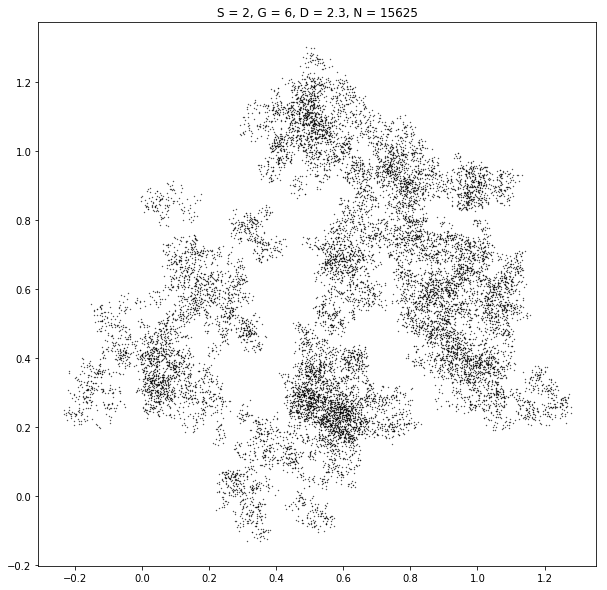

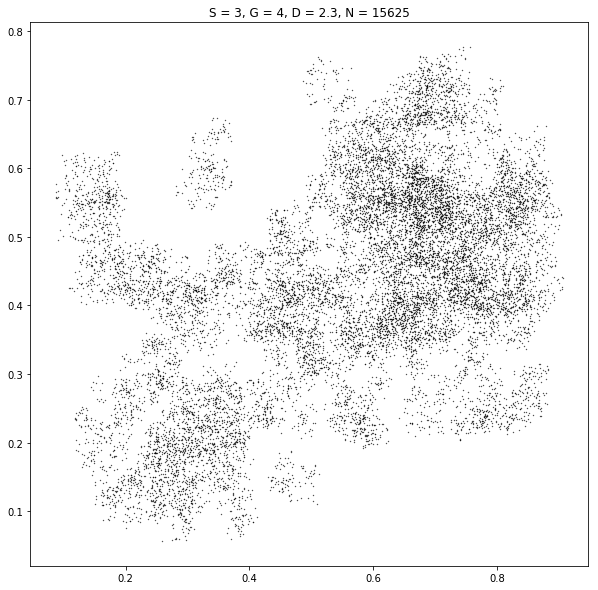

In [37]:
for i,field in enumerate(culled_star_fields):    
    plt.figure(figsize=(10,10))
    #plt.hist2d(*field, bins=128)
    plt.title('S = {}, G = {}, D = {}, N = {}'.format(S_LIST[i],G_LIST[i],D,len(field[i])))
    plt.scatter(*field, s=.1, c='k')
    plt.show()

In [41]:
separations_list = [ordered_separations(field) for field in tqdm(culled_star_fields)]
separations_list

[array([3.38106493e-05, 6.33235731e-05, 6.39820250e-05, ...,
        1.52729117e+00, 1.53016235e+00, 1.53184740e+00]),
 array([3.78235872e-05, 4.37182560e-05, 4.90536332e-05, ...,
        9.11127578e-01, 9.14198121e-01, 9.18330180e-01])]

In [7]:
s_factors = np.linspace(0,2,1000)
P_s_list = [two_pt_corr(points,separations,s) for s in tqdm(s_factors)]

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [31:35<00:00,  1.90s/it]


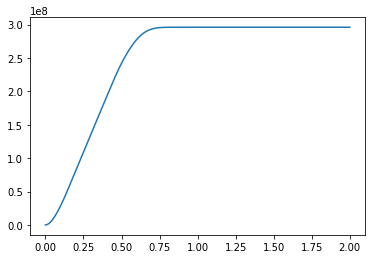

In [8]:
plt.figure()
plt.plot(s_factors,P_s_list)